# Textual similarity
This script does not take into account semantic similarity, for instance, it would recognize as differents:
over ~ above
+ using [Pyvis](https://pyvis.readthedocs.io/en/latest/index.html) library (built around the VisJS library)

In [1]:
!pip install pyvis

In [7]:
import re
import numpy as np

from nltk.metrics.distance import *

from pyvis.network import Network
import networkx as nx

## Texts

In [9]:
raw_texts = ["""
The Way that can be told of is not the eternal Way;
The name that can be named is not the eternal name.
The Nameless is the origin of Heaven and Earth;
The Named is the mother of all things.

Therefore let there always be non-being,
  so we may see their subtlety,
And let there always be being,
  so we may see their outcome.
The two are the same,
But after they are produced,
  they have different names.
""",
"""
The Nameless is the origin of Heaven and Earth;
The named is the mother of all things.

Therefore let there always be non-being,
  so we may see their subtlety,
And let there always be being,
  so we may see their outcome.
The two are the same,
But after they are produced,
  they have different names.

They both may be called deep and profound.
Deeper and more profound,
The door of all subtleties!
"""
]

## Similarity metrics
+ semantic (based on word embeddings): cosine similarity, euclidean distance
+ literal: Jaccard distance, word mover’s distance

In [10]:
# import sklearn
# , sklearn.metrics.jaccard_score,

In [11]:
def tokens_jaccard_similarity(a, b):
    # convert to set
    a = set(a.split())
    b = set(b.split())
    # calucate jaccard similarity
    return float(len(a.intersection(b))) / len(a.union(b))

# SAMPLE OUTPUTS
"""
Calculate the minimum Levenshtein edit-distance based alignment mapping between two strings. The alignment finds the mapping from string s1 to s2 that minimizes the edit distance cost. For example, mapping “rain” to “shine” would involve 2 substitutions, 2 matches and an insertion resulting in the following mapping: [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (4, 5)] NB: (0, 0)
jaccard_similarity  # Distance metric comparing set-similarity
jaro_similarity
jaro_winkler_similarity  # extension of the Jaro similarity (William E. Winkler. 1990)
"""
functions = (tokens_jaccard_similarity, jaro_similarity, jaro_winkler_similarity, edit_distance)
for func in functions:
    print(func( 'The two are the same', 'The three are the same'), func.__name__)

0.6666666666666666 tokens_jaccard_similarity
0.8134680134680135 jaro_similarity
0.888080808080808 jaro_winkler_similarity
4 edit_distance


## Preprocessing

In [12]:
def normalize(text):
    # equivalent
    return re.sub('[ \t]{2,}', ' ', text).strip()

d = "    test1 		test2  "
normalize(d)

'test1 test2'

In [13]:
# split into lines
texts = []
for text in raw_texts:
    t1 = re.split('\n', text)
    t1 = [normalize(_) for _ in t1 if _]
    texts.append(t1)
texts

[['The Way that can be told of is not the eternal Way;',
  'The name that can be named is not the eternal name.',
  'The Nameless is the origin of Heaven and Earth;',
  'The Named is the mother of all things.',
  'Therefore let there always be non-being,',
  'so we may see their subtlety,',
  'And let there always be being,',
  'so we may see their outcome.',
  'The two are the same,',
  'But after they are produced,',
  'they have different names.'],
 ['The Nameless is the origin of Heaven and Earth;',
  'The named is the mother of all things.',
  'Therefore let there always be non-being,',
  'so we may see their subtlety,',
  'And let there always be being,',
  'so we may see their outcome.',
  'The two are the same,',
  'But after they are produced,',
  'they have different names.',
  'They both may be called deep and profound.',
  'Deeper and more profound,',
  'The door of all subtleties!']]

## Matrices <-> Graphs

In [14]:
label_length = 20
def create_graph(matrix, texts, threshold=0):
    A_nodes, B_nodes = matrix.shape[0], matrix.shape[1]
    print(f'nodes: {A_nodes} from A, {B_nodes} from A , {A_nodes + B_nodes} total')
    
    nx_graph = nx.Graph()
    # nodes
    # matrix
    for i in range(A_nodes):
        global_i = i
        text = texts[0][i]
        nx_graph.add_node(global_i, size=20, group=1,
                          label=text[:label_length]+'...', title=text)
    for j in range(B_nodes):
        global_j = j + A_nodes  # avoid overlapping nodes. it's not an adjacency matrix
        text = texts[1][j]
        nx_graph.add_node(global_j, size=20, group=2,
                          label=text[:label_length]+'...', title=text)
    
    # text chain: chains items into a sequence graph
    for i in range(1, A_nodes):
        global_i = i
        nx_graph.add_edge(global_i-1, global_i, weight=1)
        
    for j in range(1, B_nodes):
        global_j = j + A_nodes  # avoid overlapping nodes. it's not an adjacency matrix
        nx_graph.add_edge(global_j-1, global_j, weight=1)
    
    nodes_indices = list(nx_graph.nodes)
    print('nodes indices: ', nodes_indices)
    print('nodes from A: ', nodes_indices[:A_nodes])
    print('nodes from B: ', nodes_indices[A_nodes:])
    
    # START NODE
    start_node_index = A_nodes + B_nodes
    nx_graph.add_node(start_node_index, size=25, group=0, label='START')
    nx_graph.add_edge(start_node_index, 0)
    nx_graph.add_edge(start_node_index, A_nodes)
    # nx_graph.add_edge(0, start_node_index)
    # nx_graph.add_edge(A_nodes, start_node_index)
    
    # edges
    for i in range(A_nodes):
        for j in range(B_nodes):
            if matrix[i,j]:
                global_j = j + A_nodes
                nx_graph.add_edge(i, global_j, weight=int(5 * matrix[i,j]))
                
    return nx_graph

In [15]:
def comparison_matrix(texts, comparison_function):
    # creates a cartesian product matrix from two texts already divide into units
    # e.g. units: lines <- paragraphs,  sentences
    # rows from argument index 0, columns from argument index 1
    matrix = np.zeros((len(texts[0]), len(texts[1])))

    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            pair = texts[0][i], texts[1][j]
            metric = comparison_function(*pair)
            matrix[i, j] = metric
            # print(metric, pair)

    return matrix

In [16]:
# Parameters

# functions = (tokens_jaccard_similarity, jaccard_similarity, jaro_similarity, jaro_winkler_similarity, edit_distance)
functions = (tokens_jaccard_similarity, jaro_similarity, jaro_winkler_similarity, edit_distance)

comparison_function = tokens_jaccard_similarity
threshold = 0.6

In [17]:
matrix = comparison_matrix(texts, comparison_function=comparison_function)
matrix.shape

(11, 12)

In [18]:
# Threshold
# float matrix -> boolean matrix
boolean_matrix = (matrix >= threshold).astype(int)
# zero all values below threshold
matrix[matrix < threshold] = 0
matrix

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.77777778, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 1.        , 0.        ,
        0.71428571, 0.        , 0.        , 0.        , 0.        ,
        0.        ,

In [19]:
print(boolean_matrix)

print("""
COMPARISON between A and B:
    - B deletions
    + B additions
    ? ambiguity (multiple edges pointing to the same node)
""")

# A: present in A, absent in B
pa = np.count_nonzero(boolean_matrix, axis=1)
for index, count in enumerate(pa):
    if count == 0:
        print('-', texts[0][index])
    elif count > 1:
        print('?:', texts[0][index])

pa = np.count_nonzero(boolean_matrix, axis=0)
for index, count in enumerate(pa):
    if count == 0:
        print('+', texts[1][index])
    elif count > 1:
        print('?:', texts[1][index])
        
# analyze crossing

[[0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 1 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0]]

COMPARISON between A and B:
    - B deletions
    + B additions
    ? ambiguity (multiple edges pointing to the same node)

- The Way that can be told of is not the eternal Way;
- The name that can be named is not the eternal name.
?: so we may see their subtlety,
?: so we may see their outcome.
?: so we may see their subtlety,
?: so we may see their outcome.
+ They both may be called deep and profound.
+ Deeper and more profound,
+ The door of all subtleties!


## Like a DNA strand

In [20]:
nx_graph = create_graph(matrix, texts)
directed=True

nt = Network(notebook=True, height="750px", width="100%",
             cdn_resources='remote', filter_menu =True,
             directed =directed)


nt.from_nx(nx_graph)
nt.show("nx.html")

nodes: 11 from A, 12 from A , 23 total
nodes indices:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
nodes from A:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
nodes from B:  [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
nx.html


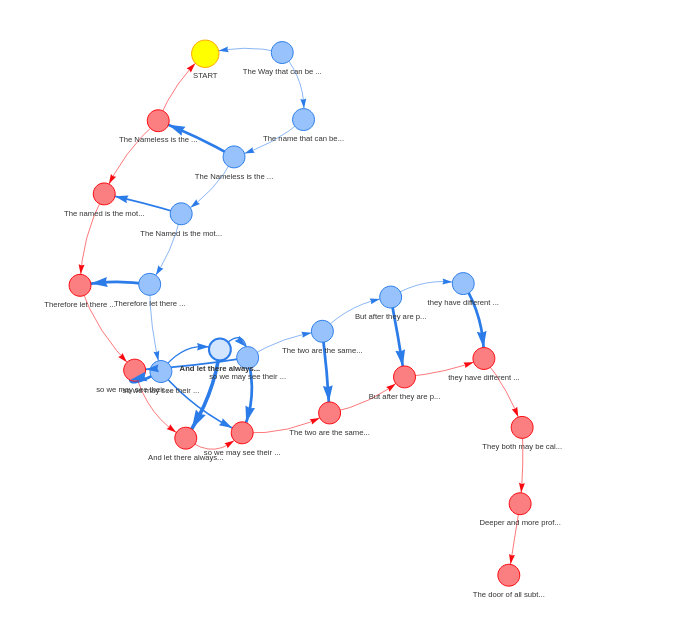